In [117]:
import numpy as np
import matplotlib.pyplot as plt

import data
import data.getSyntheticData as SyntheticData

from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.svm import OneClassSVM
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import precision_score, recall_score

from models.OCSMM import OCSMM
from utils.gridSearch import *

import pickle
import itertools


In [118]:
def compute_kernel(X, sigma):
    K = np.zeros((len(X), len(X)))
    rbf = RBF(length_scale=sigma)
    for (i, j) in itertools.combinations(range(len(X)), 2):
            kernel = rbf(X[i], X[j])
            n = X[i].shape[0]
            K[i, j] = np.sum(np.sum(kernel, axis=0), axis=0) / (n ** 2)
            K[j, i] = K[i, j]
    return K

def compute_cross_kernel(X, Y, sigma):
    K = np.zeros((len(X), len(Y)))
    rbf = RBF(length_scale=sigma)
    for (i, j) in itertools.product(range(len(X)), range(len(Y))):
            kernel = rbf(X[i], Y[j])
            n_i = X[i].shape[0]
            n_j = Y[j].shape[0]
            K[i, j] = np.sum(np.sum(kernel, axis=0), axis=0) / (n_i * n_j)
    return K

In [149]:
# Experiment plots
def plot_synthetic_data(Stest, scores):
    scores = np.squeeze(scores)
    score_plot = [np.array([sc]*Splot[idx].shape[0]) for idx, sc in enumerate(scores)]
    mini, maxi = -2.5, 2.5
    norm = plt.Normalize(mini, maxi)
    
    fig, axes = plt.subplots(2, 6, figsize=(15, 4.5), sharey=True)
    idx=0
    for ax in axes.flat:
        ax.scatter(Splot[idx][:,0], Splot[idx][:,1], 
                         c=score_plot[idx], cmap='viridis', norm=norm)
        idx+=1
        
    for a, color in zip([axes[1][9%6], axes[1][10%6], axes[1][11%6]], ['green', 'red', 'purple']):
        plt.setp(a.spines.values(), color=color, ls=':')
        plt.setp([a.get_xticklines(), a.get_yticklines()], color=color, ls=':')
    
    fig.tight_layout()
    fig.colorbar(plt.gca().get_children()[0], ax=axes.ravel().tolist()).set_label('Anomaly Score')
#     plt.savefig('synth_data.png')
    plt.show()

def plot_roc_curve(scores, Ytest):
    # Receives trained clasiffier and plots its roc curve
    # Against Test Set.
    p_values = empirical_p_values(scores)
    auc, best_cut, roc_curve = roc_auc(Ytest, p_values)
    plt.plot(roc_curve[:,0], roc_curve[:,1])
    plt.savefig('PR.png')
    plt.show()
    

In [136]:
# Generate Synthetic Data
Strain = SyntheticData.genSyntheticTrainData(n_sample=100, n_sets=50)

Stest = SyntheticData.genSyntheticTrainData(n_sample=100, n_sets=9)
X_anomaly1 = np.random.multivariate_normal(mean = [0.0, 0.0], cov = np.identity(2), size=100)
# X_anomaly2 = np.random.multivariate_normal(mean = [0.0, 0.0], cov = np.identity(2), size=100)
# X_anomaly3 = np.random.multivariate_normal(mean = [0.0, 0.0], cov = np.identity(2), size=100)
X_anomaly2 = SyntheticData.genSyntheticSet(100, pmix=[0.33, 0.64, 0.03])
X_anomaly3 = SyntheticData.genSyntheticSet(100, pmix=[0.84, 0.08, 0.08])
Stest.extend([X_anomaly1, X_anomaly2, X_anomaly3])
Ytest = [1] * 9 + [-1] * 3

In [152]:
Strain = pickle.load(open('HiggsStrain.pkl', 'rb'))
Stest = pickle.load(open('HiggsStest.pkl', 'rb'))
Ytest = pickle.load(open('HiggsYtest.pkl', 'rb'))
Ytest = [1 - 2 * y for y in Ytest]
print(len(Strain))
print(len(Stest))

100
120


sigma: 0.100000, nu: 0.100000, precision: 0.833333, recall: 1.000000
[1.71597634e-03 2.28820301e-03 2.37765759e-03 2.23325366e-03
 2.85834500e-03 1.27443536e-03 2.89079242e-03 2.26282116e-03
 2.02441326e-03 2.06703044e-03 2.33381226e-03 2.17066872e-03
 4.82355645e-04 1.76162271e-03 1.29679650e-03 1.30531347e-03
 2.43987314e-03 1.58966721e-03 7.44357561e-04 1.76171297e-03
 1.77590247e-03 1.88178860e-03 2.58542887e-03 3.41355395e-03
 1.27585906e-03 1.43296301e-03 9.63392478e-04 3.08875876e-03
 1.88966506e-03 2.10653488e-03 4.31739595e-03 1.36318060e-03
 2.23236712e-03 5.11681637e-04 2.56227397e-03 2.67287665e-03
 2.58173943e-03 2.19443726e-03 1.13433297e-03 2.17757296e-03
 5.65591745e-04 2.13611825e-03 1.48654773e-03 1.66061787e-03
 2.19257538e-03 5.44138162e-04 1.58927493e-03 2.16939769e-03
 1.99774543e-04 1.43126038e-03 2.41817663e-03 2.32130008e-03
 1.76304656e-03 8.22080936e-04 6.00959689e-04 2.39182491e-03
 3.82015735e-04 3.96543045e-04 2.74428900e-03 1.51055841e-03
 5.62006001e-04 

IndexError: list index out of range

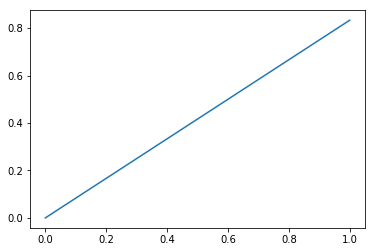

In [153]:
precision = np.zeros((10, 10))
recall = np.zeros((10, 10))
for i, sigma in enumerate([0.1]):#01 * i for i in range(1, 10)]):
    K = compute_kernel(Strain, sigma)
    Ktest = compute_cross_kernel(Stest, Strain, sigma)
    for j, nu in enumerate([0.1]):#[1 - 0.1 * i for i in range(1, 10)]):
        ocsmm = OneClassSVM(kernel='precomputed', nu=nu)
        ocsmm.fit(K)
        Ypred = ocsmm.predict(Ktest)
        scores = ocsmm.decision_function(Ktest)
        precision[i, j] = precision_score(Ytest, Ypred)
        recall[i, j] = recall_score(Ytest, Ypred)
        print('sigma: %f, nu: %f, precision: %f, recall: %f' % (sigma, nu, precision[i, j], recall[i, j]))
    plt.figure()
    plt.plot(recall[i, :], precision[i, :])
# for i in range(10):

print(scores)
plot_roc_curve(scores, Ytest)

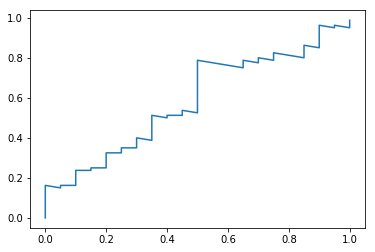

In [154]:
plot_roc_curve(scores, Ytest)

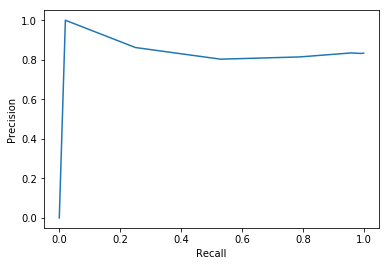

In [115]:
plt.figure()
plt.plot(recall[1, :-1], precision[1, :-1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('PR.png')

In [138]:
print(scores)
print(Ypred)
print(Ytest)

[ 0.01677015  0.02221209  0.00534195  0.01190838  0.01555555  0.00648894
  0.01435072  0.00558208  0.0059733  -0.02639796  0.02212643  0.0190522 ]
[ 1  1  1  1  1  1  1  1  1 -1  1  1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1]
